In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '마스크'만 빼서 df생성
item = '마스크'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


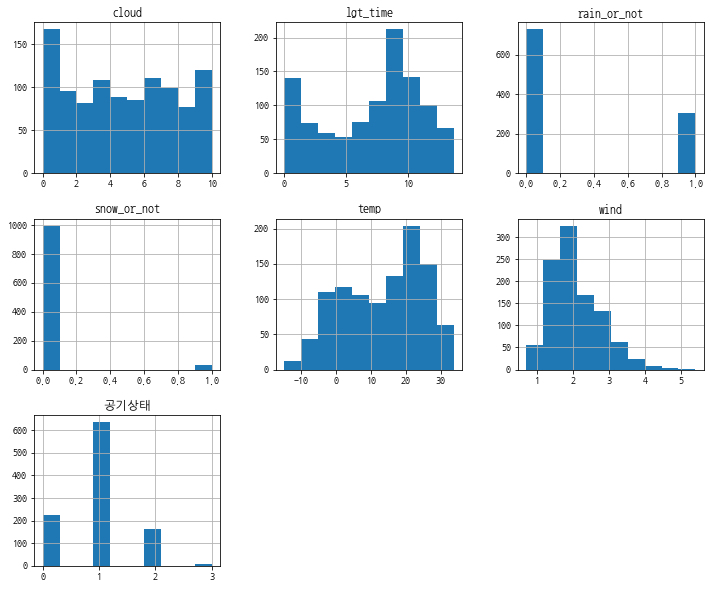

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

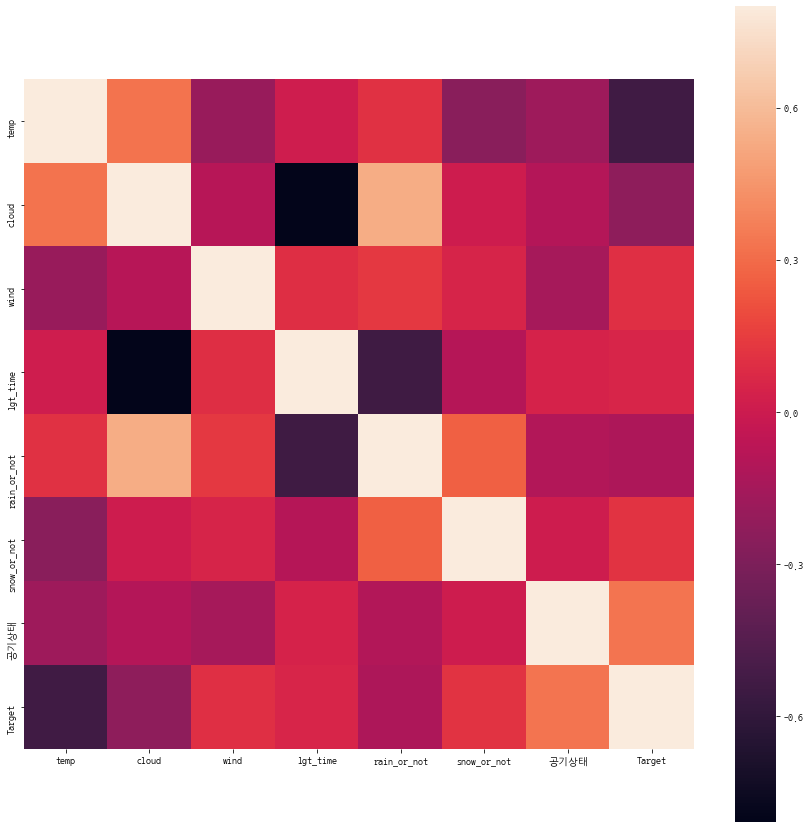

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [74]:
combined.head(2)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3
0,1.2,7.0,1.6,2.1,0,0,0,0,1,0
1,5.7,7.8,2.0,3.6,0,0,0,1,0,0


In [13]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2
0,1.2,7.0,1.6,2.1,0,0,0,0,1


In [14]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [15]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [16]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0722 10:10:19.486306  5880 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 10:10:19.502263  5880 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 10:10:19.504257  5880 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0722 10:10:19.559111  5880 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [22]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 82us/step - loss: 18.2506 - mean_absolute_error: 18.2506 - val_loss: 192.6858 - val_mean_absolute_error: 192.6858

Epoch 00001: val_loss improved from inf to 192.68582, saving model to 마스크date-Weights-001--192.68582-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 82us/step - loss: 16.8358 - mean_absolute_error: 16.8358 - val_loss: 195.2829 - val_mean_absolute_error: 195.2829

Epoch 00002: val_loss did not improve from 192.68582
Epoch 3/1000
585/585 [==============================] - 0s 77us/step - loss: 16.8749 - mean_absolute_error: 16.8749 - val_loss: 199.1780 - val_mean_absolute_error: 199.1780

Epoch 00003: val_loss did not improve from 192.68582
Epoch 4/1000
585/585 [==============================] - 0s 77us/step - loss: 19.1255 - mean_absolute_error: 19.1255 - val_loss: 194.7122 - val_mean_absolute_error: 194.7122

Epoch 00004: val_loss did not impro

585/585 [==============================] - 0s 80us/step - loss: 18.1991 - mean_absolute_error: 18.1991 - val_loss: 192.6195 - val_mean_absolute_error: 192.6195

Epoch 00036: val_loss did not improve from 191.02887
Epoch 37/1000
585/585 [==============================] - 0s 73us/step - loss: 20.2780 - mean_absolute_error: 20.2780 - val_loss: 191.9922 - val_mean_absolute_error: 191.9922

Epoch 00037: val_loss did not improve from 191.02887
Epoch 38/1000
585/585 [==============================] - 0s 78us/step - loss: 19.4512 - mean_absolute_error: 19.4512 - val_loss: 188.5406 - val_mean_absolute_error: 188.5406

Epoch 00038: val_loss improved from 191.02887 to 188.54056, saving model to 마스크date-Weights-038--188.54056-cat02-vf05.hdf5
Epoch 39/1000
585/585 [==============================] - 0s 102us/step - loss: 20.9252 - mean_absolute_error: 20.9252 - val_loss: 195.6681 - val_mean_absolute_error: 195.6681

Epoch 00039: val_loss did not improve from 188.54056
Epoch 40/1000
585/585 [========

585/585 [==============================] - 0s 85us/step - loss: 17.6764 - mean_absolute_error: 17.6764 - val_loss: 189.9813 - val_mean_absolute_error: 189.9813

Epoch 00071: val_loss did not improve from 186.73365
Epoch 72/1000
585/585 [==============================] - 0s 78us/step - loss: 16.3311 - mean_absolute_error: 16.3311 - val_loss: 195.3653 - val_mean_absolute_error: 195.3653

Epoch 00072: val_loss did not improve from 186.73365
Epoch 73/1000
585/585 [==============================] - 0s 84us/step - loss: 15.9474 - mean_absolute_error: 15.9474 - val_loss: 192.2125 - val_mean_absolute_error: 192.2125

Epoch 00073: val_loss did not improve from 186.73365
Epoch 74/1000
585/585 [==============================] - 0s 78us/step - loss: 15.6763 - mean_absolute_error: 15.6763 - val_loss: 193.2456 - val_mean_absolute_error: 193.2456

Epoch 00074: val_loss did not improve from 186.73365
Epoch 75/1000
585/585 [==============================] - 0s 78us/step - loss: 17.8801 - mean_absolute_


Epoch 00106: val_loss did not improve from 186.26620
Epoch 107/1000
585/585 [==============================] - 0s 85us/step - loss: 15.4035 - mean_absolute_error: 15.4035 - val_loss: 195.3120 - val_mean_absolute_error: 195.3120

Epoch 00107: val_loss did not improve from 186.26620
Epoch 108/1000
585/585 [==============================] - 0s 92us/step - loss: 17.2913 - mean_absolute_error: 17.2913 - val_loss: 194.9710 - val_mean_absolute_error: 194.9710

Epoch 00108: val_loss did not improve from 186.26620
Epoch 109/1000
585/585 [==============================] - 0s 87us/step - loss: 15.5878 - mean_absolute_error: 15.5878 - val_loss: 189.9140 - val_mean_absolute_error: 189.9140

Epoch 00109: val_loss did not improve from 186.26620
Epoch 110/1000
585/585 [==============================] - 0s 85us/step - loss: 15.8368 - mean_absolute_error: 15.8368 - val_loss: 193.4509 - val_mean_absolute_error: 193.4509

Epoch 00110: val_loss did not improve from 186.26620
Epoch 111/1000
585/585 [======


Epoch 00142: val_loss did not improve from 186.26620
Epoch 143/1000
585/585 [==============================] - 0s 97us/step - loss: 16.5772 - mean_absolute_error: 16.5772 - val_loss: 194.5317 - val_mean_absolute_error: 194.5317

Epoch 00143: val_loss did not improve from 186.26620
Epoch 144/1000
585/585 [==============================] - 0s 99us/step - loss: 16.1289 - mean_absolute_error: 16.1289 - val_loss: 193.2675 - val_mean_absolute_error: 193.2675

Epoch 00144: val_loss did not improve from 186.26620
Epoch 145/1000
585/585 [==============================] - 0s 109us/step - loss: 16.9213 - mean_absolute_error: 16.9213 - val_loss: 195.0477 - val_mean_absolute_error: 195.0477

Epoch 00145: val_loss did not improve from 186.26620
Epoch 146/1000
585/585 [==============================] - 0s 92us/step - loss: 16.0238 - mean_absolute_error: 16.0238 - val_loss: 199.4156 - val_mean_absolute_error: 199.4156

Epoch 00146: val_loss did not improve from 186.26620
Epoch 147/1000
585/585 [=====

585/585 [==============================] - 0s 109us/step - loss: 17.5011 - mean_absolute_error: 17.5011 - val_loss: 191.7132 - val_mean_absolute_error: 191.7132

Epoch 00178: val_loss did not improve from 181.63597
Epoch 179/1000
585/585 [==============================] - 0s 124us/step - loss: 16.2684 - mean_absolute_error: 16.2684 - val_loss: 189.8008 - val_mean_absolute_error: 189.8008

Epoch 00179: val_loss did not improve from 181.63597
Epoch 180/1000
585/585 [==============================] - 0s 133us/step - loss: 18.1206 - mean_absolute_error: 18.1206 - val_loss: 192.2753 - val_mean_absolute_error: 192.2753

Epoch 00180: val_loss did not improve from 181.63597
Epoch 181/1000
585/585 [==============================] - 0s 123us/step - loss: 18.0984 - mean_absolute_error: 18.0984 - val_loss: 186.7643 - val_mean_absolute_error: 186.7643

Epoch 00181: val_loss did not improve from 181.63597
Epoch 182/1000
585/585 [==============================] - 0s 128us/step - loss: 16.8506 - mean_


Epoch 00213: val_loss did not improve from 181.63597
Epoch 214/1000
585/585 [==============================] - 0s 130us/step - loss: 15.8669 - mean_absolute_error: 15.8669 - val_loss: 197.3238 - val_mean_absolute_error: 197.3238

Epoch 00214: val_loss did not improve from 181.63597
Epoch 215/1000
585/585 [==============================] - 0s 118us/step - loss: 15.5460 - mean_absolute_error: 15.5460 - val_loss: 190.3668 - val_mean_absolute_error: 190.3668

Epoch 00215: val_loss did not improve from 181.63597
Epoch 216/1000
585/585 [==============================] - 0s 116us/step - loss: 15.1024 - mean_absolute_error: 15.1024 - val_loss: 197.2956 - val_mean_absolute_error: 197.2956

Epoch 00216: val_loss did not improve from 181.63597
Epoch 217/1000
585/585 [==============================] - 0s 135us/step - loss: 14.8498 - mean_absolute_error: 14.8498 - val_loss: 193.9065 - val_mean_absolute_error: 193.9065

Epoch 00217: val_loss did not improve from 181.63597
Epoch 218/1000
585/585 [==

585/585 [==============================] - 0s 131us/step - loss: 15.2964 - mean_absolute_error: 15.2964 - val_loss: 197.8427 - val_mean_absolute_error: 197.8427

Epoch 00249: val_loss did not improve from 181.63597
Epoch 250/1000
585/585 [==============================] - 0s 121us/step - loss: 15.2764 - mean_absolute_error: 15.2764 - val_loss: 188.8501 - val_mean_absolute_error: 188.8501

Epoch 00250: val_loss did not improve from 181.63597
Epoch 251/1000
585/585 [==============================] - 0s 135us/step - loss: 14.5007 - mean_absolute_error: 14.5007 - val_loss: 189.5049 - val_mean_absolute_error: 189.5049

Epoch 00251: val_loss did not improve from 181.63597
Epoch 252/1000
585/585 [==============================] - 0s 126us/step - loss: 14.9485 - mean_absolute_error: 14.9485 - val_loss: 188.9689 - val_mean_absolute_error: 188.9689

Epoch 00252: val_loss did not improve from 181.63597
Epoch 253/1000
585/585 [==============================] - 0s 136us/step - loss: 15.7520 - mean_


Epoch 00284: val_loss did not improve from 181.63597
Epoch 285/1000
585/585 [==============================] - 0s 138us/step - loss: 18.1273 - mean_absolute_error: 18.1273 - val_loss: 194.7987 - val_mean_absolute_error: 194.7987

Epoch 00285: val_loss did not improve from 181.63597
Epoch 286/1000
585/585 [==============================] - 0s 148us/step - loss: 16.3551 - mean_absolute_error: 16.3551 - val_loss: 192.1259 - val_mean_absolute_error: 192.1259

Epoch 00286: val_loss did not improve from 181.63597
Epoch 287/1000
585/585 [==============================] - 0s 145us/step - loss: 17.4945 - mean_absolute_error: 17.4945 - val_loss: 184.9606 - val_mean_absolute_error: 184.9606

Epoch 00287: val_loss did not improve from 181.63597
Epoch 288/1000
585/585 [==============================] - 0s 142us/step - loss: 16.7072 - mean_absolute_error: 16.7072 - val_loss: 197.6088 - val_mean_absolute_error: 197.6088

Epoch 00288: val_loss did not improve from 181.63597
Epoch 289/1000
585/585 [==

585/585 [==============================] - 0s 142us/step - loss: 12.9391 - mean_absolute_error: 12.9391 - val_loss: 188.8390 - val_mean_absolute_error: 188.8390

Epoch 00320: val_loss did not improve from 181.63597
Epoch 321/1000
585/585 [==============================] - 0s 152us/step - loss: 14.8995 - mean_absolute_error: 14.8995 - val_loss: 191.3658 - val_mean_absolute_error: 191.3658

Epoch 00321: val_loss did not improve from 181.63597
Epoch 322/1000
585/585 [==============================] - 0s 153us/step - loss: 14.7463 - mean_absolute_error: 14.7463 - val_loss: 192.2534 - val_mean_absolute_error: 192.2534

Epoch 00322: val_loss did not improve from 181.63597
Epoch 323/1000
585/585 [==============================] - 0s 145us/step - loss: 14.0938 - mean_absolute_error: 14.0938 - val_loss: 191.9075 - val_mean_absolute_error: 191.9075

Epoch 00323: val_loss did not improve from 181.63597
Epoch 324/1000
585/585 [==============================] - 0s 165us/step - loss: 13.7331 - mean_


Epoch 00355: val_loss did not improve from 181.63597
Epoch 356/1000
585/585 [==============================] - 0s 136us/step - loss: 13.5674 - mean_absolute_error: 13.5674 - val_loss: 188.1366 - val_mean_absolute_error: 188.1366

Epoch 00356: val_loss did not improve from 181.63597
Epoch 357/1000
585/585 [==============================] - 0s 159us/step - loss: 14.2029 - mean_absolute_error: 14.2029 - val_loss: 194.5814 - val_mean_absolute_error: 194.5814

Epoch 00357: val_loss did not improve from 181.63597
Epoch 358/1000
585/585 [==============================] - 0s 152us/step - loss: 13.1720 - mean_absolute_error: 13.1720 - val_loss: 189.7230 - val_mean_absolute_error: 189.7230

Epoch 00358: val_loss did not improve from 181.63597
Epoch 359/1000
585/585 [==============================] - 0s 145us/step - loss: 13.5915 - mean_absolute_error: 13.5915 - val_loss: 195.3084 - val_mean_absolute_error: 195.3084

Epoch 00359: val_loss did not improve from 181.63597
Epoch 360/1000
585/585 [==

585/585 [==============================] - 0s 150us/step - loss: 15.6945 - mean_absolute_error: 15.6945 - val_loss: 188.9895 - val_mean_absolute_error: 188.9895

Epoch 00391: val_loss did not improve from 181.63597
Epoch 392/1000
585/585 [==============================] - 0s 148us/step - loss: 16.8682 - mean_absolute_error: 16.8682 - val_loss: 190.9174 - val_mean_absolute_error: 190.9174

Epoch 00392: val_loss did not improve from 181.63597
Epoch 393/1000
585/585 [==============================] - 0s 142us/step - loss: 15.5359 - mean_absolute_error: 15.5359 - val_loss: 188.5504 - val_mean_absolute_error: 188.5504

Epoch 00393: val_loss did not improve from 181.63597
Epoch 394/1000
585/585 [==============================] - 0s 142us/step - loss: 14.4415 - mean_absolute_error: 14.4415 - val_loss: 188.0966 - val_mean_absolute_error: 188.0966

Epoch 00394: val_loss did not improve from 181.63597
Epoch 395/1000
585/585 [==============================] - 0s 136us/step - loss: 13.4598 - mean_


Epoch 00426: val_loss did not improve from 181.63597
Epoch 427/1000
585/585 [==============================] - 0s 148us/step - loss: 14.6813 - mean_absolute_error: 14.6813 - val_loss: 189.6315 - val_mean_absolute_error: 189.6315

Epoch 00427: val_loss did not improve from 181.63597
Epoch 428/1000
585/585 [==============================] - 0s 123us/step - loss: 14.4491 - mean_absolute_error: 14.4491 - val_loss: 190.6351 - val_mean_absolute_error: 190.6351

Epoch 00428: val_loss did not improve from 181.63597
Epoch 429/1000
585/585 [==============================] - 0s 143us/step - loss: 15.9250 - mean_absolute_error: 15.9250 - val_loss: 184.1802 - val_mean_absolute_error: 184.1802

Epoch 00429: val_loss did not improve from 181.63597
Epoch 430/1000
585/585 [==============================] - 0s 140us/step - loss: 15.4963 - mean_absolute_error: 15.4963 - val_loss: 187.7889 - val_mean_absolute_error: 187.7889

Epoch 00430: val_loss did not improve from 181.63597
Epoch 431/1000
585/585 [==

585/585 [==============================] - 0s 135us/step - loss: 15.8611 - mean_absolute_error: 15.8611 - val_loss: 189.7213 - val_mean_absolute_error: 189.7213

Epoch 00462: val_loss did not improve from 181.63597
Epoch 463/1000
585/585 [==============================] - 0s 142us/step - loss: 17.2606 - mean_absolute_error: 17.2606 - val_loss: 187.2782 - val_mean_absolute_error: 187.2782

Epoch 00463: val_loss did not improve from 181.63597
Epoch 464/1000
585/585 [==============================] - 0s 155us/step - loss: 12.8385 - mean_absolute_error: 12.8385 - val_loss: 188.7759 - val_mean_absolute_error: 188.7759

Epoch 00464: val_loss did not improve from 181.63597
Epoch 465/1000
585/585 [==============================] - 0s 153us/step - loss: 14.2938 - mean_absolute_error: 14.2938 - val_loss: 188.6317 - val_mean_absolute_error: 188.6317

Epoch 00465: val_loss did not improve from 181.63597
Epoch 466/1000
585/585 [==============================] - 0s 157us/step - loss: 15.0407 - mean_

585/585 [==============================] - 0s 150us/step - loss: 15.6791 - mean_absolute_error: 15.6791 - val_loss: 188.6940 - val_mean_absolute_error: 188.6940

Epoch 00497: val_loss did not improve from 179.89284
Epoch 498/1000
585/585 [==============================] - 0s 177us/step - loss: 14.5449 - mean_absolute_error: 14.5449 - val_loss: 188.4319 - val_mean_absolute_error: 188.4319

Epoch 00498: val_loss did not improve from 179.89284
Epoch 499/1000
585/585 [==============================] - 0s 155us/step - loss: 14.8567 - mean_absolute_error: 14.8567 - val_loss: 189.6940 - val_mean_absolute_error: 189.6940

Epoch 00499: val_loss did not improve from 179.89284
Epoch 500/1000
585/585 [==============================] - 0s 184us/step - loss: 13.0138 - mean_absolute_error: 13.0138 - val_loss: 189.3104 - val_mean_absolute_error: 189.3104

Epoch 00500: val_loss did not improve from 179.89284
Epoch 501/1000
585/585 [==============================] - 0s 172us/step - loss: 13.2242 - mean_

585/585 [==============================] - 0s 184us/step - loss: 13.3256 - mean_absolute_error: 13.3256 - val_loss: 189.0561 - val_mean_absolute_error: 189.0561

Epoch 00532: val_loss did not improve from 179.77203
Epoch 533/1000
585/585 [==============================] - 0s 150us/step - loss: 12.9559 - mean_absolute_error: 12.9559 - val_loss: 189.9763 - val_mean_absolute_error: 189.9763

Epoch 00533: val_loss did not improve from 179.77203
Epoch 534/1000
585/585 [==============================] - 0s 165us/step - loss: 11.4350 - mean_absolute_error: 11.4350 - val_loss: 188.6942 - val_mean_absolute_error: 188.6942

Epoch 00534: val_loss did not improve from 179.77203
Epoch 535/1000
585/585 [==============================] - 0s 167us/step - loss: 11.9983 - mean_absolute_error: 11.9983 - val_loss: 190.9708 - val_mean_absolute_error: 190.9708

Epoch 00535: val_loss did not improve from 179.77203
Epoch 536/1000
585/585 [==============================] - 0s 179us/step - loss: 13.7367 - mean_


Epoch 00567: val_loss did not improve from 179.77203
Epoch 568/1000
585/585 [==============================] - 0s 191us/step - loss: 13.7359 - mean_absolute_error: 13.7359 - val_loss: 190.1121 - val_mean_absolute_error: 190.1121

Epoch 00568: val_loss did not improve from 179.77203
Epoch 569/1000
585/585 [==============================] - 0s 203us/step - loss: 12.2316 - mean_absolute_error: 12.2316 - val_loss: 187.3492 - val_mean_absolute_error: 187.3492

Epoch 00569: val_loss did not improve from 179.77203
Epoch 570/1000
585/585 [==============================] - 0s 177us/step - loss: 12.4508 - mean_absolute_error: 12.4508 - val_loss: 191.1558 - val_mean_absolute_error: 191.1558

Epoch 00570: val_loss did not improve from 179.77203
Epoch 571/1000
585/585 [==============================] - 0s 162us/step - loss: 13.4878 - mean_absolute_error: 13.4878 - val_loss: 188.3118 - val_mean_absolute_error: 188.3118

Epoch 00571: val_loss did not improve from 179.77203
Epoch 572/1000
585/585 [==

585/585 [==============================] - 0s 157us/step - loss: 12.4581 - mean_absolute_error: 12.4581 - val_loss: 191.0875 - val_mean_absolute_error: 191.0875

Epoch 00603: val_loss did not improve from 179.77203
Epoch 604/1000
585/585 [==============================] - ETA: 0s - loss: 13.0070 - mean_absolute_error: 13.007 - 0s 150us/step - loss: 12.8738 - mean_absolute_error: 12.8738 - val_loss: 185.5441 - val_mean_absolute_error: 185.5441

Epoch 00604: val_loss did not improve from 179.77203
Epoch 605/1000
585/585 [==============================] - 0s 193us/step - loss: 13.0127 - mean_absolute_error: 13.0127 - val_loss: 189.9596 - val_mean_absolute_error: 189.9596

Epoch 00605: val_loss did not improve from 179.77203
Epoch 606/1000
585/585 [==============================] - 0s 730us/step - loss: 11.4588 - mean_absolute_error: 11.4588 - val_loss: 185.5590 - val_mean_absolute_error: 185.5590

Epoch 00606: val_loss did not improve from 179.77203
Epoch 607/1000
585/585 [===============

585/585 [==============================] - 0s 184us/step - loss: 13.1488 - mean_absolute_error: 13.1488 - val_loss: 190.0491 - val_mean_absolute_error: 190.0491

Epoch 00638: val_loss did not improve from 179.77203
Epoch 639/1000
585/585 [==============================] - 0s 205us/step - loss: 12.9674 - mean_absolute_error: 12.9674 - val_loss: 186.4713 - val_mean_absolute_error: 186.4713

Epoch 00639: val_loss did not improve from 179.77203
Epoch 640/1000
585/585 [==============================] - 0s 167us/step - loss: 13.5716 - mean_absolute_error: 13.5716 - val_loss: 184.4686 - val_mean_absolute_error: 184.4686

Epoch 00640: val_loss did not improve from 179.77203
Epoch 641/1000
585/585 [==============================] - 0s 189us/step - loss: 13.4642 - mean_absolute_error: 13.4642 - val_loss: 187.0192 - val_mean_absolute_error: 187.0192

Epoch 00641: val_loss did not improve from 179.77203
Epoch 642/1000
585/585 [==============================] - 0s 189us/step - loss: 12.6985 - mean_


Epoch 00673: val_loss did not improve from 179.77203
Epoch 674/1000
585/585 [==============================] - 0s 150us/step - loss: 12.6774 - mean_absolute_error: 12.6774 - val_loss: 190.9481 - val_mean_absolute_error: 190.9481

Epoch 00674: val_loss did not improve from 179.77203
Epoch 675/1000
585/585 [==============================] - 0s 150us/step - loss: 12.6591 - mean_absolute_error: 12.6591 - val_loss: 189.4189 - val_mean_absolute_error: 189.4189

Epoch 00675: val_loss did not improve from 179.77203
Epoch 676/1000
585/585 [==============================] - 0s 150us/step - loss: 12.2566 - mean_absolute_error: 12.2566 - val_loss: 194.3987 - val_mean_absolute_error: 194.3987

Epoch 00676: val_loss did not improve from 179.77203
Epoch 677/1000
585/585 [==============================] - 0s 157us/step - loss: 11.4583 - mean_absolute_error: 11.4583 - val_loss: 188.5463 - val_mean_absolute_error: 188.5463

Epoch 00677: val_loss did not improve from 179.77203
Epoch 678/1000
585/585 [==

585/585 [==============================] - 0s 147us/step - loss: 13.1235 - mean_absolute_error: 13.1235 - val_loss: 189.3330 - val_mean_absolute_error: 189.3330

Epoch 00709: val_loss did not improve from 179.77203
Epoch 710/1000
585/585 [==============================] - 0s 143us/step - loss: 14.6135 - mean_absolute_error: 14.6135 - val_loss: 181.8007 - val_mean_absolute_error: 181.8007

Epoch 00710: val_loss did not improve from 179.77203
Epoch 711/1000
585/585 [==============================] - 0s 147us/step - loss: 14.5943 - mean_absolute_error: 14.5943 - val_loss: 187.6031 - val_mean_absolute_error: 187.6031

Epoch 00711: val_loss did not improve from 179.77203
Epoch 712/1000
585/585 [==============================] - 0s 165us/step - loss: 11.4560 - mean_absolute_error: 11.4560 - val_loss: 190.2146 - val_mean_absolute_error: 190.2146

Epoch 00712: val_loss did not improve from 179.77203
Epoch 713/1000
585/585 [==============================] - 0s 160us/step - loss: 12.1065 - mean_


Epoch 00744: val_loss did not improve from 179.77203
Epoch 745/1000
585/585 [==============================] - 0s 172us/step - loss: 11.5614 - mean_absolute_error: 11.5614 - val_loss: 185.6563 - val_mean_absolute_error: 185.6563

Epoch 00745: val_loss did not improve from 179.77203
Epoch 746/1000
585/585 [==============================] - 0s 148us/step - loss: 13.4663 - mean_absolute_error: 13.4663 - val_loss: 187.6350 - val_mean_absolute_error: 187.6350

Epoch 00746: val_loss did not improve from 179.77203
Epoch 747/1000
585/585 [==============================] - 0s 162us/step - loss: 12.5435 - mean_absolute_error: 12.5435 - val_loss: 185.2879 - val_mean_absolute_error: 185.2879

Epoch 00747: val_loss did not improve from 179.77203
Epoch 748/1000
585/585 [==============================] - 0s 167us/step - loss: 14.9614 - mean_absolute_error: 14.9614 - val_loss: 191.6979 - val_mean_absolute_error: 191.6979

Epoch 00748: val_loss did not improve from 179.77203
Epoch 749/1000
585/585 [==

585/585 [==============================] - 0s 169us/step - loss: 11.7429 - mean_absolute_error: 11.7429 - val_loss: 188.2335 - val_mean_absolute_error: 188.2335

Epoch 00780: val_loss did not improve from 179.77203
Epoch 781/1000
585/585 [==============================] - 0s 174us/step - loss: 12.7129 - mean_absolute_error: 12.7129 - val_loss: 192.1224 - val_mean_absolute_error: 192.1224

Epoch 00781: val_loss did not improve from 179.77203
Epoch 782/1000
585/585 [==============================] - 0s 172us/step - loss: 11.9829 - mean_absolute_error: 11.9829 - val_loss: 183.7887 - val_mean_absolute_error: 183.7887

Epoch 00782: val_loss did not improve from 179.77203
Epoch 783/1000
585/585 [==============================] - 0s 159us/step - loss: 10.8025 - mean_absolute_error: 10.8025 - val_loss: 185.0399 - val_mean_absolute_error: 185.0399

Epoch 00783: val_loss did not improve from 179.77203
Epoch 784/1000
585/585 [==============================] - 0s 176us/step - loss: 11.7829 - mean_


Epoch 00815: val_loss did not improve from 179.77203
Epoch 816/1000
585/585 [==============================] - 0s 155us/step - loss: 10.9264 - mean_absolute_error: 10.9264 - val_loss: 189.2194 - val_mean_absolute_error: 189.2194

Epoch 00816: val_loss did not improve from 179.77203
Epoch 817/1000
585/585 [==============================] - 0s 147us/step - loss: 13.1334 - mean_absolute_error: 13.1334 - val_loss: 187.9334 - val_mean_absolute_error: 187.9334

Epoch 00817: val_loss did not improve from 179.77203
Epoch 818/1000
585/585 [==============================] - 0s 167us/step - loss: 11.6197 - mean_absolute_error: 11.6197 - val_loss: 186.2687 - val_mean_absolute_error: 186.2687

Epoch 00818: val_loss did not improve from 179.77203
Epoch 819/1000
585/585 [==============================] - 0s 157us/step - loss: 12.5492 - mean_absolute_error: 12.5492 - val_loss: 180.6360 - val_mean_absolute_error: 180.6360

Epoch 00819: val_loss did not improve from 179.77203
Epoch 820/1000
585/585 [==

585/585 [==============================] - 0s 136us/step - loss: 11.5604 - mean_absolute_error: 11.5604 - val_loss: 185.6263 - val_mean_absolute_error: 185.6263

Epoch 00851: val_loss did not improve from 179.62147
Epoch 852/1000
585/585 [==============================] - 0s 188us/step - loss: 12.2105 - mean_absolute_error: 12.2105 - val_loss: 185.6301 - val_mean_absolute_error: 185.6301

Epoch 00852: val_loss did not improve from 179.62147
Epoch 853/1000
585/585 [==============================] - 0s 138us/step - loss: 10.0790 - mean_absolute_error: 10.0790 - val_loss: 187.2712 - val_mean_absolute_error: 187.2712

Epoch 00853: val_loss did not improve from 179.62147
Epoch 854/1000
585/585 [==============================] - 0s 133us/step - loss: 11.6698 - mean_absolute_error: 11.6698 - val_loss: 189.9235 - val_mean_absolute_error: 189.9235

Epoch 00854: val_loss did not improve from 179.62147
Epoch 855/1000
585/585 [==============================] - 0s 140us/step - loss: 13.0600 - mean_

585/585 [==============================] - 0s 170us/step - loss: 10.8415 - mean_absolute_error: 10.8415 - val_loss: 190.0209 - val_mean_absolute_error: 190.0209

Epoch 00886: val_loss did not improve from 177.90685
Epoch 887/1000
585/585 [==============================] - 0s 155us/step - loss: 10.8727 - mean_absolute_error: 10.8727 - val_loss: 184.4532 - val_mean_absolute_error: 184.4532

Epoch 00887: val_loss did not improve from 177.90685
Epoch 888/1000
585/585 [==============================] - 0s 167us/step - loss: 11.1978 - mean_absolute_error: 11.1978 - val_loss: 185.6511 - val_mean_absolute_error: 185.6511

Epoch 00888: val_loss did not improve from 177.90685
Epoch 889/1000
585/585 [==============================] - 0s 170us/step - loss: 9.9496 - mean_absolute_error: 9.9496 - val_loss: 184.9123 - val_mean_absolute_error: 184.9123

Epoch 00889: val_loss did not improve from 177.90685
Epoch 890/1000
585/585 [==============================] - 0s 164us/step - loss: 10.0268 - mean_ab


Epoch 00921: val_loss did not improve from 177.90685
Epoch 922/1000
585/585 [==============================] - 0s 136us/step - loss: 13.4486 - mean_absolute_error: 13.4486 - val_loss: 185.6045 - val_mean_absolute_error: 185.6045

Epoch 00922: val_loss did not improve from 177.90685
Epoch 923/1000
585/585 [==============================] - 0s 153us/step - loss: 12.6179 - mean_absolute_error: 12.6179 - val_loss: 186.6766 - val_mean_absolute_error: 186.6766

Epoch 00923: val_loss did not improve from 177.90685
Epoch 924/1000
585/585 [==============================] - 0s 164us/step - loss: 12.8178 - mean_absolute_error: 12.8178 - val_loss: 182.9256 - val_mean_absolute_error: 182.9256

Epoch 00924: val_loss did not improve from 177.90685
Epoch 925/1000
585/585 [==============================] - 0s 159us/step - loss: 10.9105 - mean_absolute_error: 10.9105 - val_loss: 182.6735 - val_mean_absolute_error: 182.6735

Epoch 00925: val_loss did not improve from 177.90685
Epoch 926/1000
585/585 [==

585/585 [==============================] - 0s 152us/step - loss: 10.7028 - mean_absolute_error: 10.7028 - val_loss: 186.7358 - val_mean_absolute_error: 186.7358

Epoch 00957: val_loss did not improve from 177.90685
Epoch 958/1000
585/585 [==============================] - 0s 145us/step - loss: 12.0646 - mean_absolute_error: 12.0646 - val_loss: 185.2560 - val_mean_absolute_error: 185.2560

Epoch 00958: val_loss did not improve from 177.90685
Epoch 959/1000
585/585 [==============================] - 0s 155us/step - loss: 12.8287 - mean_absolute_error: 12.8287 - val_loss: 188.1798 - val_mean_absolute_error: 188.1798

Epoch 00959: val_loss did not improve from 177.90685
Epoch 960/1000
585/585 [==============================] - 0s 152us/step - loss: 11.2936 - mean_absolute_error: 11.2936 - val_loss: 190.3909 - val_mean_absolute_error: 190.3909

Epoch 00960: val_loss did not improve from 177.90685
Epoch 961/1000
585/585 [==============================] - 0s 152us/step - loss: 12.2189 - mean_


Epoch 00992: val_loss did not improve from 177.90685
Epoch 993/1000
585/585 [==============================] - 0s 160us/step - loss: 10.6704 - mean_absolute_error: 10.6704 - val_loss: 186.8540 - val_mean_absolute_error: 186.8540

Epoch 00993: val_loss did not improve from 177.90685
Epoch 994/1000
585/585 [==============================] - 0s 143us/step - loss: 12.6656 - mean_absolute_error: 12.6656 - val_loss: 181.7823 - val_mean_absolute_error: 181.7823

Epoch 00994: val_loss did not improve from 177.90685
Epoch 995/1000
585/585 [==============================] - 0s 176us/step - loss: 16.6011 - mean_absolute_error: 16.6011 - val_loss: 187.8772 - val_mean_absolute_error: 187.8772

Epoch 00995: val_loss did not improve from 177.90685
Epoch 996/1000
585/585 [==============================] - 0s 167us/step - loss: 11.3885 - mean_absolute_error: 11.3885 - val_loss: 190.5833 - val_mean_absolute_error: 190.5833

Epoch 00996: val_loss did not improve from 177.90685
Epoch 997/1000
585/585 [==

In [24]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '마스크date-Weights-885--177.90685-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [25]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.871
검증세트점수 : 0.486
XGBoost을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.691
검증세트점수 : 0.531
LinearRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.393
검증세트점수 : 0.427
RidgeRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.372
검증세트점수 : 0.393
LassoRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.393
검증세트점수 : 0.427
OLS을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.393
검증세트점수 : 0.427


In [26]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
customF = formulaGen(target='qty',ind_features=['temp', '공기상태_0', '공기상태_1', '공기상태_2'])
# customF = 'qty ~ temp + cloud  + rain_or_not + 공기상태_0 + 공기상태_1+공기상태_2'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

마스크 ols model
사람이 직접 식을 때려 박았을때 : 0.426


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           7.55e-76
Time:                        10:20:09   Log-Likelihood:                -4841.4
No. Observations:                 732   AIC:                             9693.
Df Residuals:                     727   BIC:                             9716.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    968.9243     90.599     10.695      0.000     791.058    1146.791
temp         -10.7926      0.587    -18.389      0.000     -11.945      -9.640
공기상태_0      -506.9996     92.251     -5.496      0.000    -688.110    -325.890
공기상태_1      -474.7309     90.899     -5.223      0.000    -653.187    -296.275
공기상태_2      -361.3370     91.942     -3.930      0.000    -541.841    -180.833
==============================================================================
Omnibus:                      130.215   Durbin-Watson:                   0.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.884
Skew:                           1.024   Prob(JB):                     7.41e-56
Kurtosis:                       5.032   Cond. No.                         465.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [28]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.20
Linear 모델 MAPE 		: 0.41
Ridge 모델 MAPE 		: 0.43
Lasso 모델 MAPE 		: 0.41
OLS 모델 MAPE 			: 0.41


In [250]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape
Xy['date'] = result_date_col

In [253]:
XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,aircon,date,PM10
0,266,1.2,7.0,1.6,2.1,0,0,0,0,1,0,나쁨,2016-01-01,68.6965


In [240]:
print(Xy.shape)
print(result_df.shape)

(1031, 12)
(1031, 16)


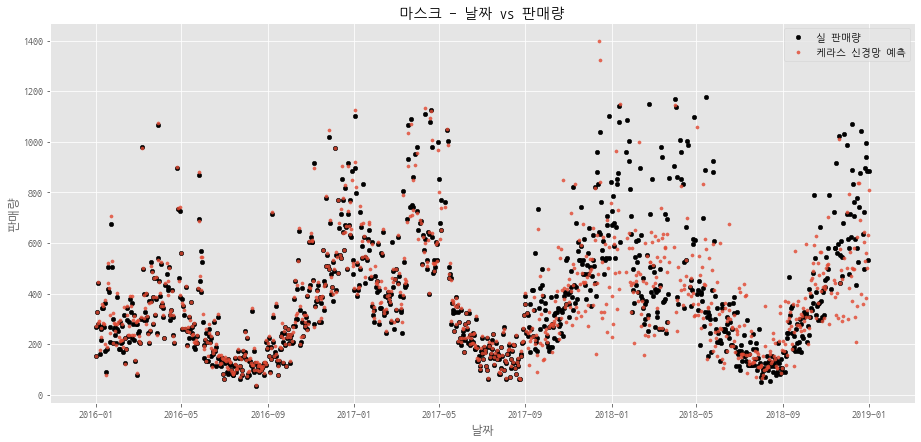

In [262]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=-1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '날짜') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('날짜')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [220]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

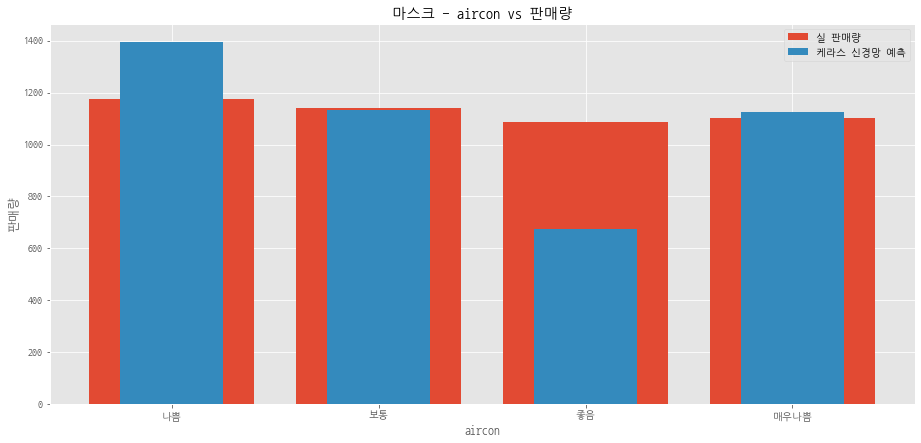

In [221]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [222]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [223]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,266,271.603180,334.6,499.699921,575.546377,564.124251,576.420972,594.636312,0.021065,...,1.120768,1.166996,1.235475,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,154,154.674255,324.8,465.789185,420.286797,412.959960,420.309992,432.675906,0.004378,...,1.681558,1.729286,1.809584,5.7,7.8,2.0,3.6,0,0,보통


In [224]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [225]:
p_df = pd.pivot_table(result_Xy[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'aircon']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['aircon'],
                     aggfunc = np.sum)
p_df = p_df.iloc[[3,2,0,1],[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
aircon,,,,,,,,
좋음,62569,63000.714844,59693.553208,59510.232266,60013.842779,65227.8,61102.019092,65077.128906
보통,238780,226824.781250,228293.074131,228167.959189,228674.495506,231521.9,229775.069674,234547.890625
나쁨,87523,82659.718750,80416.384966,80321.379335,80459.451905,82222.0,79638.816364,81278.187500
매우나쁨,5458,4488.500488,4924.461264,5258.717836,5207.004509,3528.2,2735.969213,3111.157715


In [ ]:
# 8개 판매량

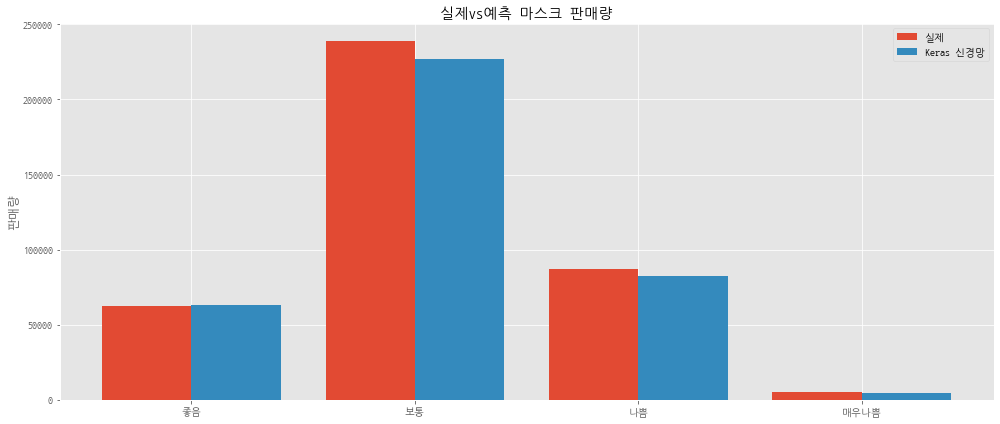

In [264]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('실제vs예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(p_df.index)

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()